
<h2 style="text-align:center;" > Estudio de viabilidad en la delimitación de coberturas con imágenes satelitales mediante el modelo Segment Anything: Comparación con la metodología CORINE Land Cover en el municipio de Guatavita.</h2>

<h2 style="text-align:center;" >Tutorial Descarga de imagenes y procesamiento</h2>

Autores:
*   **Cristian Stiven Florez Macias**
*   **Sergio Andres Escobar Eslava** 

##  Indice
1. [INSTALACIÓN DE PAQUETES](#packages)
2. [IMPORTAR PAQUETES](#import)
3. [AUTENTICACION](#auth)
4. [ZONA DE ESTUDIO](#area)
8. [SAM](#sam)


## 1. INSTALACIÓN DE PAQUETES

<a name="packages"></a>

## 1. INSTALACIÓN DE PAQUETES
* **Earth Engine**: Es un paquete de python que permite la integracion con la plataforma en la nube de Google, mediante el lenguaje de programacion python permite realizar el analisis y procesamiento de las imagenes satelitales usadas en el proyecto.
* **Geemap**: Es un paquete de python de codigo abierto que hace mas interactivo el analisis geoespacial y visualizacion con earth engine, nos brinda herramientas para la visualizacion de imagenes y capas.
* **Geopandas**: Es un paquete de python de codigo abierto pensado para facilitar las operaciones con tipos geometricos (Punto, Multi-punto, Linea, Multi-linea, Poligono y Multi-poligono) mediante shapely.
* **Rasterio**: Es un paquete de python de codigo abierto que facilita la lectura y escritura de formatos para almacenar datos raster mediante una API de python que se apoya en matrices N-dimensionales y geojson.
* **eeconvert**: Es un paquete en python aun en version pre alpha que se usa para realizar conversiones desde formatos empleados em Google Earth Engine a formatos SIG como GeoDataframes, es importante en el proyecto para convertir la region de un archivo GeoDataFrame a un archivo compatible con EarthEngine como featureCollection.

In [2]:
!pip install geemap geopandas rasterio eeconvert

  Using cached eeconvert-0.1.22-py2.py3-none-any.whl.metadata (497 bytes)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.13.1-py3-none-any.whl.metadata (1.7 kB)
Using cached eeconvert-0.1.22-py2.py3-none-any.whl (5.7 kB)
   ---------------------------------------- 0.0/14.0 MB ? eta -:--:--
   ----------- ---------------------------- 4.2/14.0 MB 21.3 MB/s eta 0:00:01
   --------------------- ------------------ 7.6/14.0 MB 19.2 MB/s eta 0:00:01
   ----------------------------------- ---- 12.3/14.0 MB 20.3 MB/s eta 0:00:01
   ---------------------------------------- 14.0/14.0 MB 19.6 MB/s  0:00:00
Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
Using cached s3transfer-0.13.1-py3-none-any.whl (85 kB)
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 20.6 MB/s  0:00:00

   ----- ---------------------------------- 1/7 [greenlet]
   ----- -------------------------------

<a name="import"></a>

## 2. IMPORTAR PAQUETES

Los paquetes en python son una excelente opcion para estructurar los modulos realizados en python, nos permite cargar un "módulo A.B designa un submódulo B en un paquete llamado A."(pythondocs, s.f) por ejemplo tomamos el multimodulo a: geemap con su modulo b: eefolium y le designamos un submodulo emap, esto nos da la posibilidad de no preocuparnos por nombres duplicados en nuestro proyecto.


In [135]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import geojson
import eeconvert as eec
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage import exposure
import rasterio
import numpy as np

### Creacion de una funcion parametrizada para imprimir los graficos usados en el cuaderno
La función `plot_map` permite visualizar los mapas generados en el cuaderno a partir de datos guardados en el tipo GeoDataFrame, esta funcion separa en dos partes la salida grafica:
* En el lado derecho se imprime el titulo de la salida grafica ademas de el grafico con la grilla georreferenciada con sus respectivas unidades y del
* En el lado izquierdo se imprime informacion de la institucion, leyenda del mapa, sistema de referencia y escala del mapa.

In [136]:
def plot_map(gdf, title, projection, legend_label='Leyenda', scale='1:10000'):
    """
    Grafica los mapas con los elementos de la leyenda personalizados.

    Parámetros:
        gdf (GeoDataFrame): GeoDataFrame de GeoPandas que contiene la geometría y los atributos a graficar.
        title (str): Título del mapa principal.
        projection (str o CRS): Proyección espacial del GeoDataFrame.
        legend_label (str): Nombre de la columna del GeoDataFrame que se usará para la simbologia y la leyenda.

    Descripción:
        Esta función grafica un mapa con una leyenda lateral personalizada y ajusta la posición de la leyenda de categorías a la derecha del gráfico principal. Además, muestra información institucional y de proyección en el panel lateral derecho.
    """
    fig = plt.figure(figsize=(14, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])
    
    # Grilla 1: Mapa principal
    ax_map = fig.add_subplot(gs[0, 0])
    gdf.plot(legend_label, ax=ax_map, legend=True)
    ax_map.set_title(title, fontsize=14, pad=18, fontweight='bold')
    ax_map.set_xlabel('Longitud (°)')
    ax_map.set_ylabel('Latitud (°)')
    
    legend = ax_map.get_legend()
    legend.set_bbox_to_anchor((1.25, 0.5))
    legend.set_title('shapeName')
    
    # Grilla 2: Leyenda
    ax_legend = fig.add_subplot(gs[0, 1])
    ax_legend.axis('off')
    ax_legend.text(0.2, 0.95, 'Universidad Distrital', fontsize=12, fontweight='bold', ha='center', va='top')
    ax_legend.text(0.2, 0.90, 'Francisco José de Caldas', fontsize=12, fontweight='bold', ha='center', va='top')
    ax_legend.text(0.2, 0.1, projection, fontsize=10, ha='center', va='center')
    ax_legend.text(0.2, 0.15, f'Escala: {scale}', fontsize=10, ha='center', va='center')

    plt.show()

<a name="import"></a>

## 3. AUTENTICACIÓN
Antes de iniciar debemos estar registrados en Google Engine y crear un nuevo proyecto.El termino de autenticacion se refiere al proceso por el cual se va a realizar el inicio de sesion mediante el cliente de python a Google Earth Engine, esta funcion usa el estandar OAuth2.0 y genera un token persistente almacenado en nuestra maquina local o el servicio de Google Collab, el metodo inicializar toma el token persistente y carga nuestro proyecto de Google Drive en la maquina local.

In [137]:
ee.Authenticate()
ee.Initialize(project='ee-adam-segmentation')

<a name="import"></a>

# 4. ZONA DE ESTUDIO

Descripcion realizada en la monografia

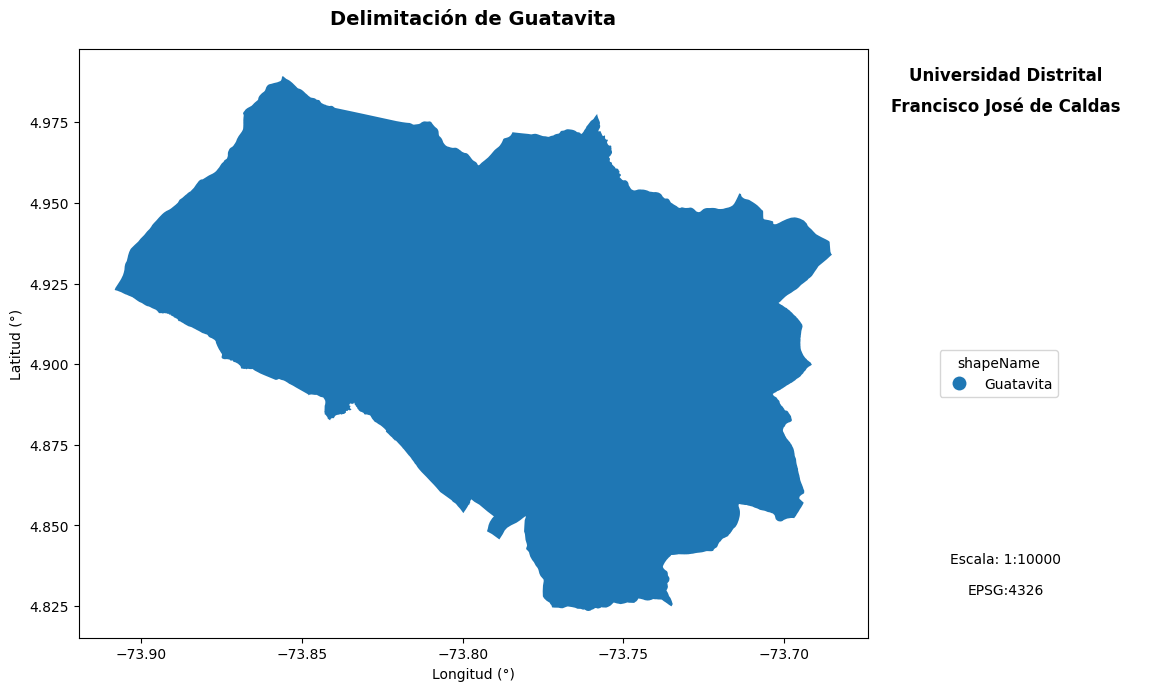

In [139]:
ISO = 'COL' # "COL" es el codigo ISO para Colombia
ADM = 'ADM2' # Equivalente a distritos administrativos

# Busqueda de geoBoundaries mediante el servicio    
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Guardado del resultado en formato GeoJSON en nuestra carpeta usada para guardar este tipo de archivos
filename = '../geojson/geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Leer los datos con GeoPandas
geoboundary = gpd.read_file(filename)
shape_name = 'Guatavita'
guatavita = geoboundary[geoboundary.shapeName == shape_name]
# Imprimimos la zona de estudio para guatavita
plot_map(
    guatavita,
    title=f"Delimitación de {shape_name}",
    projection=guatavita.crs,
    legend_label="shapeName"
)
guatavita.to_file('../geojson/guatavita.geojson', driver='GeoJSON')

# Obtener la geometría de forma para Boyaca
regiongdf  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = regiongdf.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(regiongdf) #geodataframe a feature collection

<a name="import"></a>

# 5. DESCARGAR IMAGEN SENTINEL


In [ ]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2021-01-01',
    max_date='2024-12-31',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generamos una imagen de Sentinel-2 utilizando la API de Python 
    para Google Earth Engine filtrada por nubes, mediana agregada

    Argumentos:
      region (ee.Geometry): La geometría del área de interés a filtrar.
      product (str): ID activo de Earth Engine
       Puede encontrar la lista completa de ID de ImageCollection
        en https://developers.google.com/earth-engine/datasets
      min_date (str): Fecha mínima para adquirir colección de imágenes satelitales
      max_date (str): Fecha maxima para adquirir colección de imágenes satelitales
      range_min (int): Valor mínimo para el rango de visalización
      range_max (int): Valor maximo para el rango de visalización
      cloud_pct (float): El porcentaje de cobertura de nubes por el que filtrar (predeterminado 10)

    La funcion retorna:
      ee.image.Image: La imagen generada de Sentinel-2 recortada en la región de interés
    """

    #Generar compuesto agregado mediano
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Obtener las bandas RGB
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Tener en cuenta que el valor máximo de las bandas RGB está establecido en 65535
    # porque las bandas de Sentinel-2 son enteros de 16 bits
    # con un rango numérico completo de [0, 65535] (el máximo es 2^16 - 1);
    # Sin embargo, los valores reales son mucho más pequeños que el valor máximo.
    # Fuente: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

## Análisis de histogramas

In [ ]:
# Cargamos la imagen y separamos sus bandas en archivos por separado
dir_image = "../tiff/sentinel_guatavita.tif"
image = rasterio.open(dir_image)
img_red = image.read(1)
img_green = image.read(2)
img_blue = image.read(3)

# Calculamos el histograma de cada banda
co_green,ce_green = exposure.histogram(img_green)
co_blue,ce_blue = exposure.histogram(img_blue)
co_red,ce_red = exposure.histogram(img_red)

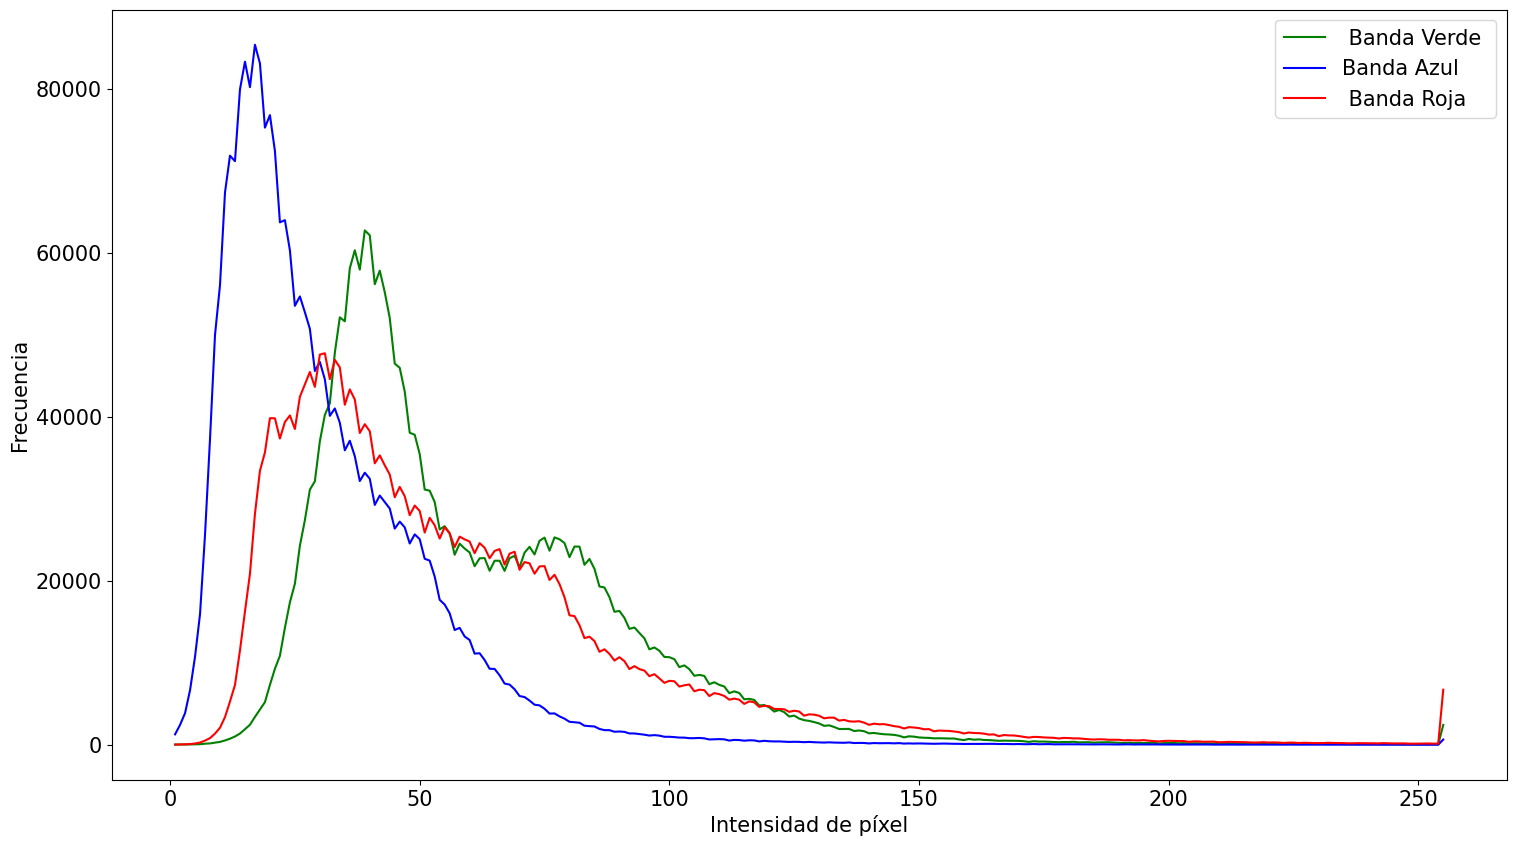

In [151]:
fig , ax = plt. subplots ( figsize =(18 , 10))
ax.plot( ce_green [1::] , co_green [1::] , "g" , label =" Banda Verde ")
ax.plot( ce_blue [1::] , co_blue [1::] ,"blue",label ="Banda Azul" )
ax.plot( ce_red [1::] , co_red [1::] ,"red",label =" Banda Roja" )
plt.legend(loc="upper right", fontsize=15)
plt.xlabel("Intensidad de píxel", fontsize=15)
plt.ylabel("Frecuencia", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Realce de imágenes satelitales

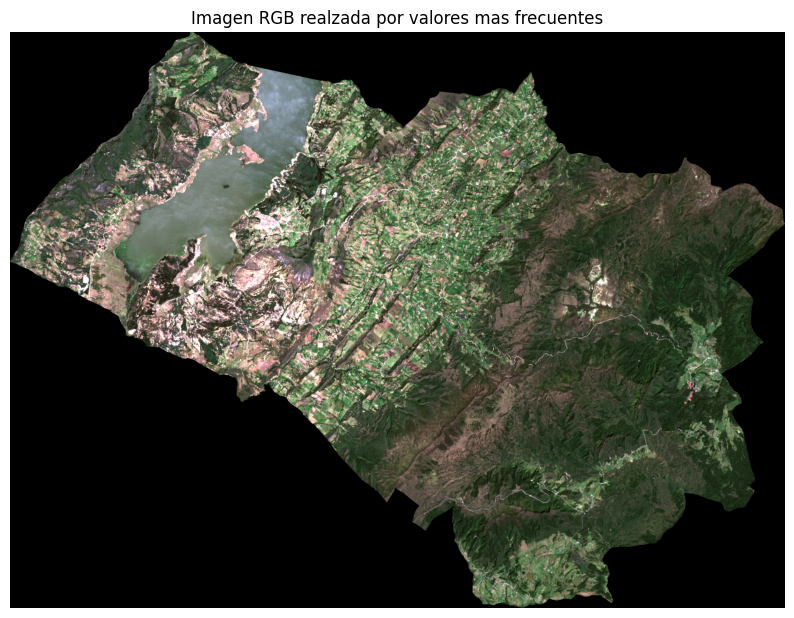

In [160]:
# A cada capa de la imagen le aplicamos el realce
new_red = exposure.rescale_intensity(img_red, in_range=(0, 155), out_range=(0, 255))
new_blue = exposure.rescale_intensity(img_blue, in_range=(0, 100), out_range=(0, 255))
new_green = exposure.rescale_intensity(img_green, in_range=(0, 155), out_range=(0, 255))

# unimos de nuevo las capas
new_rgb =np.dstack((new_red, new_green, new_blue))

#visualizamos la imagen con el realce
plt.figure(figsize=(10, 10))
plt.imshow(new_rgb.astype(np.uint8))
plt.title('Imagen RGB realzada por valores mas frecuentes')
plt.axis('off')
plt.show()


